# Galaxy Morphology Classification

This project aims to classify galaxies according to their morphology into three main categories:
- **Elliptical galaxies**
- **Spiral galaxies**
- **Merging galaxies**

The classification is performed using physical and morphological measurements derived from astronomical surveys, combined with supervised machine learning techniques.

In [ ]:
import numpy as np
import pandas as pd
import os
import tarfile
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, confusion_matrix, classification_report
import time
import matplotlib.pyplot as plt
from PIL import Image
import io

## Dataset Description

In [ ]:
# Get the datasets

path_morphology = r"C:/Users/migue/OneDrive/Documentos/datasets galaxias/morphology_catalogue.csv"
data_morph = pd.read_csv(path_morphology)

path_physical = r"C:/Users/migue/OneDrive/Documentos/datasets galaxias/useful_physical_measurements.parquet"
data_phys = pd.read_parquet(path_physical)


data = pd.merge(
    left= data_phys,
    right= data_morph,
    on= 'object_id',
    how= "inner"
)

print(data.shape)

(380111, 106)


The dataset consists of more than 380,000 galaxies and over 100 measured variables, including:
- Morphological indicators derived from Galaxy Zoo classifications
- Physical and photometric measurements used as input features for machine learning models

Only galaxies with reliable classifications are retained in order to reduce label noise.

### Data Cleaning and Feature Selection

We remove galaxies whose classifications do not meet the recommended quality criteria.
A subset of variables is selected:
- Morphological fractions used to define galaxy classes
- Physical features used as input for the predictive models

All infinite and missing values are removed to ensure numerical stability during training.

In [ ]:
# Remove galaxies with less reliable classifications
data = data[data['warning_galaxy_fails_training_cuts'] == False]

# Select variables used to define galaxy groups and variables used to train the models
variables = ['ellipticity', 'log_kron_radius', 'log_segmentation_area', 'concentration', 'mumax_minus_mag_x', 'mumax_minus_mag_y', 'gini', 'asymmetry', 'smoothness', 'moment_20', 'sersic_sersic_vis_index', 'phz_pp_median_stellarmass', 'flux_detection_total_y', 'flux_vis_1fwhm_aper_y']
comparar = ['smooth-or-featured_smooth_fraction', 'smooth-or-featured_featured-or-disk_fraction', 'merging_major-disturbance_fraction', 'merging_merger_fraction', 'object_id', 'tile_index_y', 'jpg_loc_gz_arcsinh_vis_y']

# DataFrame containing only the selected variables
data_clean = data[variables + comparar].copy()

# The infinity and NaN values are remove
data_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
data_clean = data_clean.dropna()

num, var = data_clean.shape
print(f'Cleaning the dataframe, it lefts {num} galaxies.')

Cleaning the dataframe, it lefts 183435 galaxies.


## Galaxy Morphology Definition

Galaxies are divided into three morphological classes based on Galaxy Zoo vote fractions:

- **Elliptical**: smooth galaxies with a high smoothness fraction
- **Spiral**: featured or disk galaxies with a high disk fraction
- **Merging**: galaxies showing strong merger or disturbance signatures

![galaxias](Imagenes_Galaxias/TIPOS%20DE%20GALAXIAS.jpg)


In [ ]:
# A new column is created to assign morphological classes to the galaxies.
df = data_clean.copy()
df['morphology'] = 'none'

# Here there is the way to classify the galaxies
cond_eliptica = df['smooth-or-featured_smooth_fraction'] > 0.7
cond_espiral = df['smooth-or-featured_featured-or-disk_fraction'] > 0.7
cond_merging = df['merging_major-disturbance_fraction'] + df['merging_merger_fraction'] > 0.4

# Since merging galaxies may also present elliptical or spiral features, the merging category is given priority.
df.loc[cond_eliptica, 'morphology'] = 'elliptical'
df.loc[cond_espiral, 'morphology'] = 'spiral'
df.loc[cond_merging, 'morphology'] = 'merging'
# Eliminate the ones with no classification
df = df[df['morphology'] != 'none']

# Differents dataframes are create for the different types of galaxies
df_elliptical = df[df['morphology'] == 'elliptical'].copy()
df_spiral = df[df['morphology'] == 'spiral'].copy()
df_merging = df[df['morphology'] == 'merging'].copy()

In [ ]:
num, var = df.shape
print(f'Finally we will work with {num} galaxies, classified as:')
df['morphology'].value_counts()

Finalmente tendremos 109829 galaxias, repartidas como:


morphology
elliptical    51664
spiral        38406
merging       19759
Name: count, dtype: int64

## Visualization of Galaxy Images

To better understand the morphological differences between classes, we visualize random samples of galaxy images.
The images are extracted directly from a compressed archive and displayed alongside their corresponding object identifiers.
This function are inspired by the work of [Soliao's Github](https://github.com/soliao/Galaxy-Zoo-Classification/tree/main), but addapted to my context.

In [ ]:
tar_path = r'C:/Users/migue/OneDrive/Documentos/datasets galaxias/cutouts_jpg_gz_arcsinh_vis_y.tar'
tar = tarfile.open(tar_path, 'r')

# Create a dictionary: {filename: tar member object}
tar_index = {os.path.basename(m.name): m for m in tar.getmembers() if m.isfile()}


def plot_samples_from_tar(df):
    # Randomly select n galaxies from the DataFrame
    samples = df.sample(12)
    
    # Set up the grid (2 rows, 6 columns)
    fig, axes = plt.subplots(2, 6, figsize=(15, 6))
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        ax = axes.flat[i]
        
        # Extract the image file path from the corresponding column
        full_path = row['jpg_loc_gz_arcsinh_vis_y']
        if pd.isna(full_path):
            ax.text(0.5, 0.5, "No path available", ha='center')
            ax.axis('off')
            continue
            
        filename = os.path.basename(full_path)
        
        if filename in tar_index:
            # Extract and read the image directly from memory
            member = tar_index[filename]
            file_content = tar.extractfile(member).read()
            img = Image.open(io.BytesIO(file_content))
            
            ax.imshow(img)
            # Display the object ID as the title
            ax.set_title(f"ID: {row['object_id']}", fontsize=8)
        else:
            ax.text(0.5, 0.5, "Not found in TAR", ha='center', color='red')
        
        ax.axis('off')
    
    plt.show()


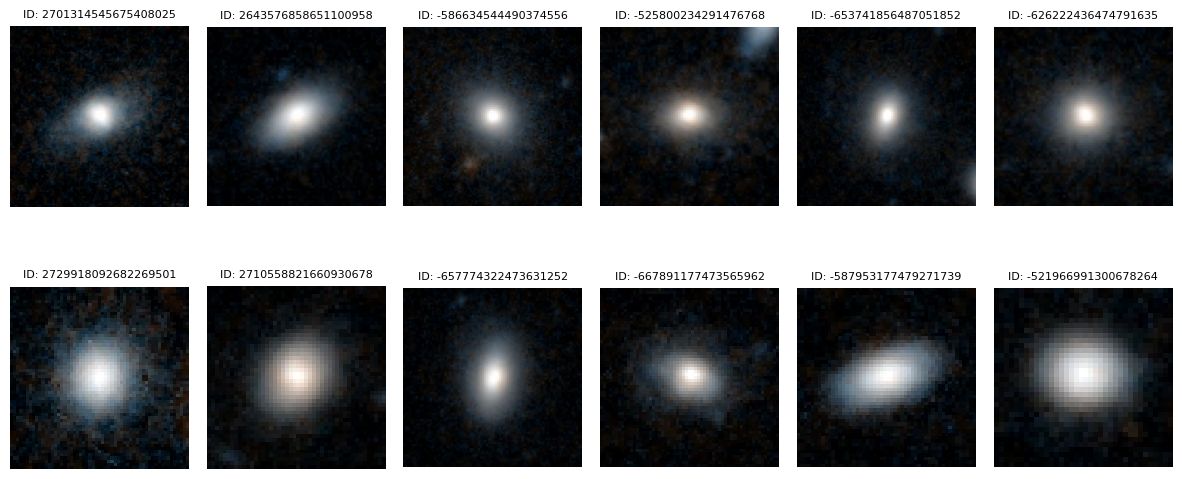

In [ ]:
plot_samples_from_tar(df_elliptical)

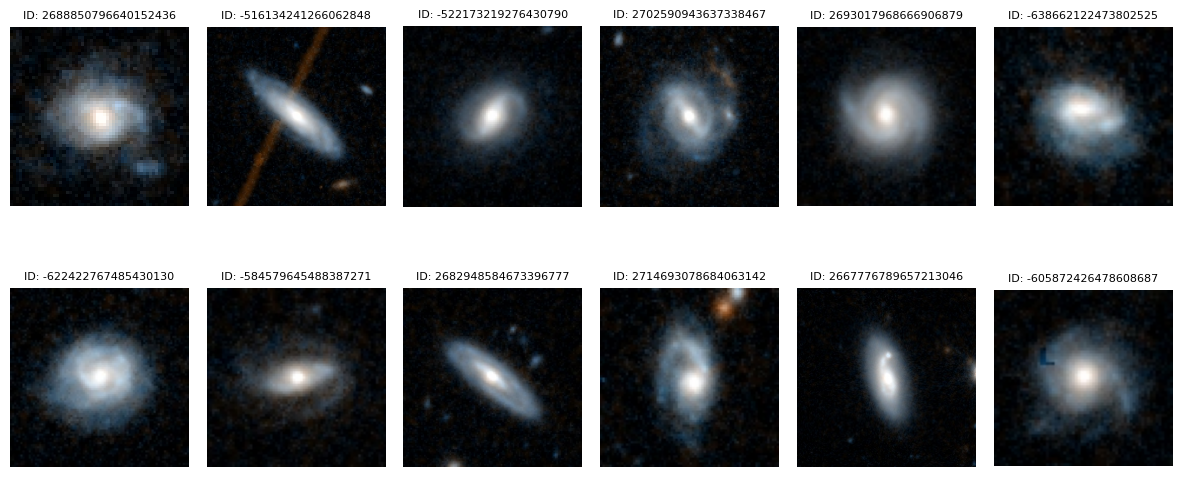

In [ ]:
plot_samples_from_tar(df_spiral)

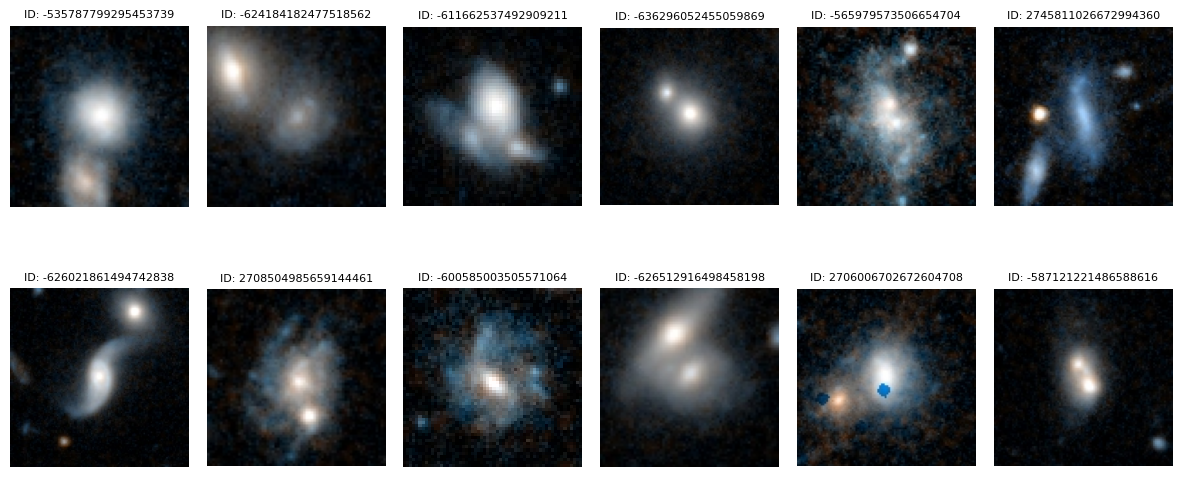

In [ ]:
plot_samples_from_tar(df_merging)

## Machine Learning Models

Two supervised learning models are implemented and compared:

- **Support Vector Machine (SVM)** with a linear kernel
- **K-Nearest Neighbors (KNN)**

The dataset is split into training (80%) and testing (20%) subsets.
All input features are standardized prior to training.

In [ ]:
X = df.drop(comparar + ['morphology'], axis=1)
y = df['morphology'].copy()

# Normalize data
X_norm = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, stratify=y, random_state=42)


#### SVM

In [ ]:
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=True)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

c:\Users\migue\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### KNN

The optimal number of neighbors is determined by evaluating the balanced accuracy score for different values of *k*.
Execution time is also recorded in order to assess the computational cost of the model.

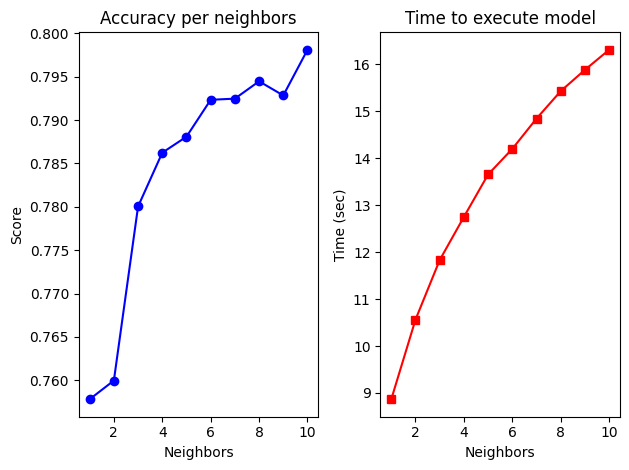

In [ ]:
k_lim = 10
k_values = range(1, k_lim+1)
accuracy = np.zeros(k_lim)
total_time = np.zeros(k_lim)


for i in k_values:
    start_time = time.time()
    knn_i = KNeighborsClassifier(n_neighbors=i)
    knn_i.fit(X_train, y_train)
    y_pred_knn = knn_i.predict(X_test)
    accuracy[i-1] = balanced_accuracy_score(y_test, y_pred_knn)
    end_time = time.time()
    total_time[i-1] = end_time - start_time

# Graphs:
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, posición 1
plt.plot(k_values, accuracy, marker= 'o', color= 'b')
plt.title('Accuracy per neighbors')
plt.xlabel('Neighbors')
plt.ylabel('Score')

plt.subplot(1, 2, 2) # 1 fila, 2 columnas, posición 2
plt.plot(k_values, total_time, marker='s', color='r', linestyle='-')
plt.title('Time to execute model')
plt.xlabel('Neighbors')
plt.ylabel('Time (sec)')

plt.tight_layout()
plt.show()

With k=10 it is higher the time it takes to create and fit the model, however the accuracy it is way better.

In [ ]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

### Model Evaluation

Model performance is evaluated using:
- Balanced accuracy score
- Precision, recall, and F1-score
- Confusion matrices

Balanced accuracy is used to account for class imbalance among the different galaxy morphologies.


In [ ]:
print('--------- MODEL SVM EVALUATION: --------')
print(classification_report(y_test, y_pred_svm))
print(f'Accuracy: {balanced_accuracy_score(y_test, y_pred_svm)}\n\n')

print('--------- MODEL KNN EVALUATION: --------')
print(classification_report(y_test, y_pred_knn))
print(f'Accuracy: {balanced_accuracy_score(y_test, y_pred_knn)}')

--------- MODEL SVM EVALUATION: --------
              precision    recall  f1-score   support

  elliptical       0.90      0.91      0.90     10333
     merging       0.67      0.65      0.66      3952
      spiral       0.80      0.81      0.80      7681

    accuracy                           0.83     21966
   macro avg       0.79      0.79      0.79     21966
weighted avg       0.82      0.83      0.82     21966

Accuracy: 0.7873188580885174


--------- MODEL KNN EVALUATION: --------
              precision    recall  f1-score   support

  elliptical       0.90      0.95      0.92     10333
     merging       0.74      0.61      0.67      3952
      spiral       0.83      0.84      0.83      7681

    accuracy                           0.85     21966
   macro avg       0.82      0.80      0.81     21966
weighted avg       0.84      0.85      0.84     21966

Accuracy: 0.7981092504021086


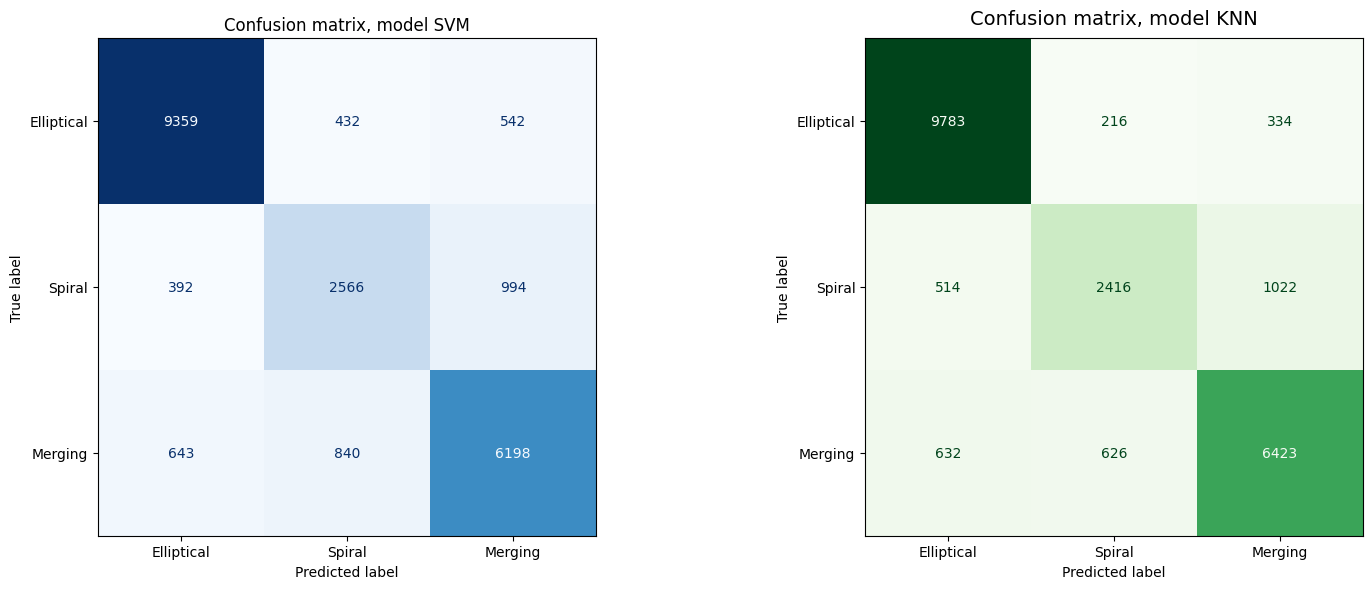

In [ ]:
# Confusion matrix plots:
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_knn = confusion_matrix(y_test, y_pred_knn)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Elliptical', 'Spiral', 'Merging'])
disp_svm.plot(cmap='Blues', ax=ax[0], colorbar=False)
ax[0].set_title('Confusion matrix, model SVM')


disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Elliptical', 'Spiral', 'Merging'])
disp_knn.plot(cmap='Greens', ax=ax[1], colorbar=False)
ax[1].set_title('Confusion matrix, model KNN', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

Both model have high accuracy choosing between spiral and elliptical, however they don't have that accuracy with the ones which are merging.